In [1]:
import pandas as pd
!pip install datasets
from transformers import EarlyStoppingCallback
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
!pip install -q sacremoses
from transformers import AutoTokenizer
from datasets import Dataset
from google.colab import files
from transformers import TrainingArguments, Trainer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from transformers import AutoModelForSequenceClassification
uploaded = files.upload()




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 19.4 MB/s eta 0:00:00


Saving df.pkl to df.pkl


In [2]:
df = pd.read_pickle("df.pkl") # wczytanie danych

df['labels'] = df['intencja'].astype('category').cat.codes # liczby zamiast etykiet
label_map = dict(enumerate(df['intencja'].astype('category').cat.categories)) # mapa etykiet

# train test val split
dataset = Dataset.from_pandas(df[['tekst', 'labels']])
dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_valid = dataset["train"].train_test_split(test_size=0.1, seed=42)

dataset["train"] = train_valid["train"]
dataset["val"] = train_valid["test"]


In [3]:
model_name = "allegro/herbert-base-cased" # polski model llm
tokenizer = AutoTokenizer.from_pretrained(model_name) # tokenizer do modelu

def tokenize_function(example): # tokenizacja
    return tokenizer(example["tekst"], padding="max_length", truncation=True, max_length=128)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# setup modelu
num_labels = len(df['labels'].unique()) # liczba klas
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

Map:   0%|          | 0/4803 [00:00<?, ? examples/s]

Map:   0%|          | 0/1335 [00:00<?, ? examples/s]

Map:   0%|          | 0/534 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allegro/herbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
def compute_metrics(eval_pred): # obliczanie metryk
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1) # zmiana logitow na indeksy klas z najwyzszym prawdopodobienstwem
    acc = accuracy_score(labels, preds) # accuracy
    f1 = f1_score(labels, preds, average='weighted') # f1
    return {"accuracy": acc, "f1": f1}

# parametry treningowe
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch", # ewaluacja po kazdej epoce
    save_strategy="epoch", # zapisywanie modelu po kazdej epoce
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs", # katalog na logi treningu
    load_best_model_at_end=True, # po treningu wczytaj najlepszy model
    metric_for_best_model="f1", # wybor najlepszego modelu po f1
    logging_steps=50,
    report_to="none"
)

In [5]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)] # zatrzymanie po 2 epokach bez poprawy
)

trainer.train() # trenowanie modelu

trainer.save_model("evaluation-classifier-herbert") # zapis modelu


/tmp/ipython-input-1477304217.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': 0}.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.441800,0.369169,0.919476,0.918083
2,0.150700,0.217023,0.955056,0.954921
3,0.045400,0.176865,0.962547,0.962542



 Ewaluacja na zbiorze testowym:


{'eval_loss': 0.1985132098197937, 'eval_accuracy': 0.9588014981273408, 'eval_f1': 0.9587163658961234, 'eval_runtime': 9.6753, 'eval_samples_per_second': 137.981, 'eval_steps_per_second': 17.261, 'epoch': 3.0}


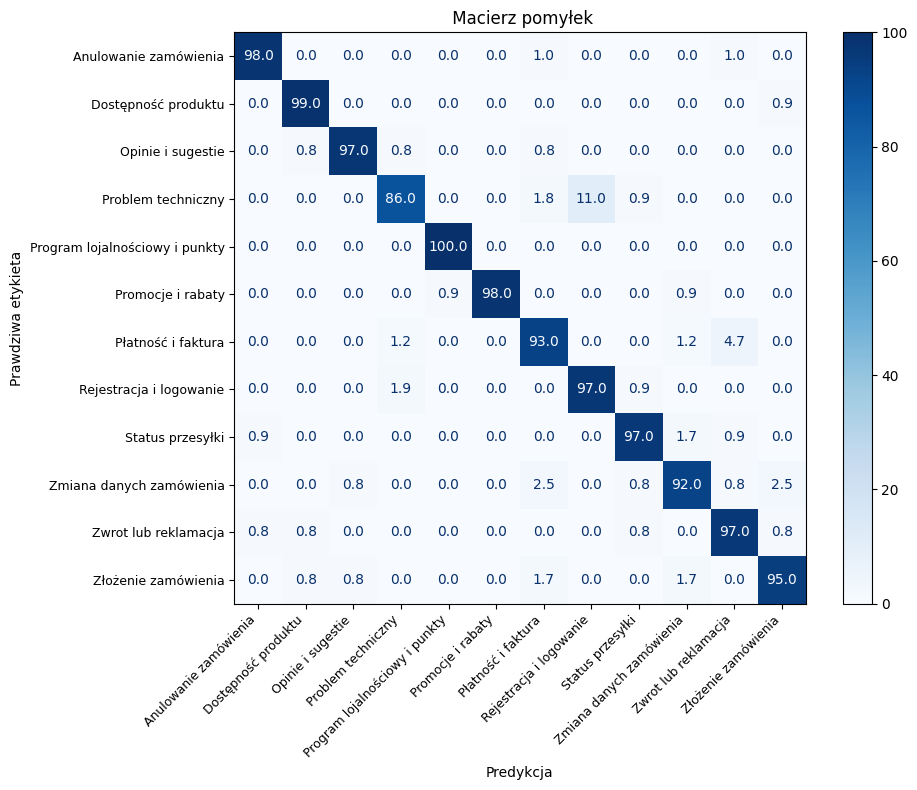

In [9]:
# ewaluacja
print("\n Ewaluacja na zbiorze testowym:")
metrics = trainer.evaluate(tokenized_dataset["test"])
print(metrics)


preds = trainer.predict(tokenized_dataset["test"])


# tworzenie confusion matrix

y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred, normalize='true') * 100
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map.values()))

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap='Blues', ax=ax, colorbar=True)
plt.title(" Macierz pomyłek")
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.xlabel("Predykcja")
plt.ylabel("Prawdziwa etykieta")

for text in disp.text_.ravel():
    text.set_text(f"{float(text.get_text()):.1f}")

plt.tight_layout()
plt.show()